# CNN with Keras on MNIST data

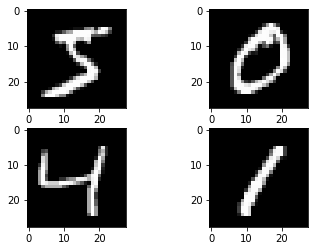

In [4]:
# Load thad the MNIST data and plot the first 4 images in the training set
import keras
from keras.datasets import mnist 
import matplotlib.pyplot as plt
# load (downloaded if needed) the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray')) 
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray')) 
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray')) 
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [5]:
# import other classes and functions 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

# fix random seed for reproducibility
import numpy as np 
np.random.seed(7)

In [6]:
# check Python, TensorFlow and Keras version

print('Python version : ', sys.version) 
print('TensorFlow version : ', tf.__version__) 
print('Keras version : ', keras.__version__)

Python version :  3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
TensorFlow version :  1.14.0
Keras version :  2.3.0


As we already loaded the MNIST dataset, we now just reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions (Conv2D) expect pixel values with the dimensions `[height][width][channels]`. In the case of RGB, the first- dimension channels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every colour image. In the case of MNIST where the channels values are grey scale, the pixel dimension is set to 1.


In [7]:
img_rows = 28
img_cols = 28
input_shape = (img_rows, img_cols, 1)

# reshape to be [samples][height][width][channels] for Keras
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1) 
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [9]:
# normalise inputs from 0-255 to 0-1
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255.

In [10]:
# print to check input shape
print('x_train shape:', x_train.shape) 
print(x_train.shape[0], 'train samples') 
print(x_test.shape[0], 'test samples')


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Apply `one hot encoding` to labels 
A one hot encoding is a representation of categorical variables as binary vectors. This first requires that the categorical values be mapped to integer values. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1. For example, if we had the sequence: ‘red’, ‘red’, ‘green’. We could represent it with the integer encoding: 0, 0, 1. 

We would like to give the network more expressive power to learn a probability-like number for each possible label value.

In [11]:
# apply one hot encoding to labels

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes) 
y_test = keras.utils.to_categorical(y_test, num_classes)

### Define neural network model

1. The first hidden layer is a convolutional layer called a `Conv2D`. The layer has 32 feature maps, with the size of 5 × 5 and a rectifier (`𝑟𝑒𝑙𝑢`) activation function. This is the input layer, expecting images with the structure outline above.
2. Next, we define a pooling layer that takes the maximum value called `MaxPooling2D`. It is configured with a pool size of 2 × 2.
3. The second hidden layer is also a `Conv2D`. The layer has 64 features maps, with the size of 5 × 5 and a `𝑟𝑒𝑙𝑢` activation function.
4. Next, we define a `MaxPooling2D` again. It is configured with a pool size of 2 × 2.
5. The next layer is a regularization layer using dropout called `Dropout`. It is configured to randomly exclude 25% of neurons in the layer in order to reduce overfitting.
6. Next is a layer that converts the 2D matrix data to a vector called `𝐹𝑙𝑎𝑡𝑡𝑒𝑛`. It allows the output to be processed by standard fully connected layers.
7. Next a fully connected layer with 1000 neurons and `𝑟𝑒𝑙𝑢` function is used.
8. We again use `Dropout`. It is configured to randomly exclude 50% of neurons in the layer.
9. Finally, the output layer has 10 neurons for the 10 classes and a `softmax activation function` to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm. A depiction of the network structure is provided below.

In [12]:
model = Sequential()
# Layer 1
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
# Layer 2
model.add(Conv2D(64, (2, 2), activation='relu', padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2)))
# Fully Connected Layer 1
model.add(Dropout(0.25))
model.add(Flatten())
# Fully Connected Layer 2
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)            

### Compile and fit the model.
The CNN is fit over 12 epochs with a batch size of 128 as defined above. The `𝑣𝑒𝑟𝑏𝑜𝑠𝑒` setting changes the way you see the training progress for each epoch. For example, `𝑣𝑒𝑟𝑏𝑜𝑠𝑒 = 0` will show you nothing (silent), `𝑣𝑒𝑟𝑏𝑜𝑠𝑒 = 1` will show you an animated progress bar like this: [===========] and `𝑣𝑒𝑟𝑏𝑜𝑠𝑒 = 2` will just mention the number of epoch like this: `Epoch 1/10`

In [22]:
opt = 'adam'
loss = 'categorical_crossentropy' 
metrics = ['accuracy']
# these values are chosen via trial and error
batch_size = 128 
epochs = 12

model.compile(optimizer=opt, loss=loss, metrics=metrics)
# fit the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.33,validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 32s 533us/step - loss: 0.1284 - accuracy: 0.9592 - val_loss: 0.0771 - val_accuracy: 0.9766
Epoch 2/12
60000/60000 [==============================] - 32s 532us/step - loss: 0.1194 - accuracy: 0.9636 - val_loss: 0.0731 - val_accuracy: 0.9782
Epoch 3/12
60000/60000 [==============================] - 33s 550us/step - loss: 0.1146 - accuracy: 0.9632 - val_loss: 0.0668 - val_accuracy: 0.9789
Epoch 4/12
60000/60000 [==============================] - 33s 554us/step - loss: 0.1041 - accuracy: 0.9672 - val_loss: 0.0627 - val_accuracy: 0.9812
Epoch 5/12
60000/60000 [==============================] - 34s 565us/step - loss: 0.0954 - accuracy: 0.9699 - val_loss: 0.0593 - val_accuracy: 0.9830
Epoch 6/12
60000/60000 [==============================] - 32s 534us/step - loss: 0.0920 - accuracy: 0.9711 - val_loss: 0.0580 - val_accuracy: 0.9831
Epoch 7/12
60000/60000 [==============================] 

In [16]:
model.evaluate(x=x_test,y=y_test,batch_size=batch_size, verbose = 1)

10000/10000 [==============================] - 1s 84us/step


[0.08899033047780394, 0.9718999862670898]

In [18]:
# How many images are misclassified?
predicted = model.predict(x_test)    
result = np.absolute(y_test-predicted)

array([[1.9159183e-09, 7.9297271e-09, 2.0617726e-05, ..., 1.8900633e-04,
        1.8025261e-08, 6.8210084e-06],
       [2.6276178e-10, 1.4479570e-03, 1.4625788e-03, ..., 2.8637256e-11,
        1.7567770e-07, 1.3802458e-14],
       [3.4612410e-06, 8.8685751e-04, 6.8640336e-05, ..., 4.3222666e-04,
        1.4386595e-04, 7.8854109e-06],
       ...,
       [8.5622143e-12, 1.3833068e-07, 3.6124825e-10, ..., 8.6100154e-05,
        4.8311307e-07, 2.2380899e-03],
       [1.2974099e-08, 4.6845738e-08, 4.0532112e-11, ..., 2.3063414e-08,
        6.7233015e-04, 1.3969064e-09],
       [2.3982313e-06, 7.6716833e-10, 3.0779017e-06, ..., 2.6761818e-11,
        2.2579975e-08, 8.3325219e-10]], dtype=float32)

KeyError: 'acc'

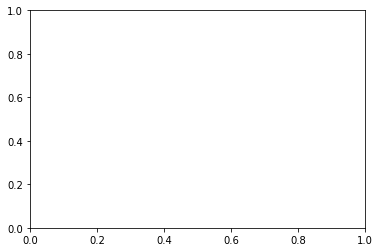

In [23]:
# Run the below code blocks and analyse the plots. What do these plots tell? 

print(history)
fig1, ax_acc = plt.subplots() 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right') 
plt.show()
fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model - Loss')
plt.legend(['Training', 'Validation'], loc='upper right') 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.show()

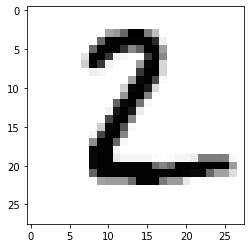

The Answer is  [2]


In [21]:
# Run the below code block and interpret the results.
n=1
plt.imshow(x_test[n].reshape(28, 28), cmap='Greys', interpolation='nearest') 
plt.show()
print('The Answer is ', model.predict_classes(x_test[n].reshape((1, 28, 28, 1))))